In [1]:
from label_data_utilities import *
from data_utilities import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)

# Experiment data and labels directories
data_dir = os.path.join('..', 'static', 'data')
my_data_dir = os.path.join(data_dir, 'my_dialogues')
other_data_dir = os.path.join(data_dir, 'other_dialogues')
user_data_dir = os.path.join(data_dir, 'user_dialogues')
labels_dir = os.path.join(data_dir, 'labels')

# Processed data and label data directories
results_dir = 'results'
label_data_dir = 'label_data'

# Paths to label agreement, timing and confidence rating data
agreement_data_dir = os.path.join(results_dir, 'agreement_data')

# Load the user data and labels
user_data = load_user_data(user_data_dir)
labels = load_labels(labels_dir, user_data)

# List of sets
sets_list = ['set_1', 'set_2', 'set_3', 'set_4', 'set_5']

# Lists of dialogue corpora and groups
dialogue_groups = dict()
dialogue_groups['practice_dialogue'] = ['practice']
dialogue_groups['kvret_dialogues'] = ['test_28', 'test_52', 'test_96', 'test_129', 'test_102']
dialogue_groups['babl_dialogues'] = ['task1_test_290', 'task1_test_428', 'task1_test_555', 'task1_test_564', 'task1_test_894']
dialogue_groups['task-oriented_dialogues'] = dialogue_groups['kvret_dialogues'] + dialogue_groups['babl_dialogues']

dialogue_groups['scose_dialogues'] = ['jason-mammoth', 'jason-clone', 'jason-accident', 'lynne-hunter', 'lynne-tipsy']
dialogue_groups['cabnc_dialogues'] = ['KB7RE015', 'KBKRE03G', 'KDARE00G', 'KE2RE00Y', 'KBERE00G']
dialogue_groups['non-task-oriented_dialogues'] = dialogue_groups['scose_dialogues'] + dialogue_groups['cabnc_dialogues']

dialogue_type_groups = ['task-oriented_dialogues', 'non-task-oriented_dialogues']
dialogue_corpora_groups = ['kvret_dialogues', 'babl_dialogues', 'scose_dialogues', 'cabnc_dialogues']

dialogue_sets = {'set_1': ['jason-mammoth', 'test_28', 'task1_test_290', 'KB7RE015'],
                 'set_2': ['jason-clone', 'test_52', 'task1_test_428', 'KBKRE03G'],
                 'set_3': ['jason-accident', 'test_96', 'task1_test_555', 'KDARE00G'],
                 'set_4': ['lynne-hunter', 'test_129', 'task1_test_564', 'KE2RE00Y'],
                 'set_5': ['lynne-tipsy', 'test_102', 'task1_test_894', 'KBERE00G'],
                 'practice_dialogue': ['practice']}

In [2]:
# # Might have to update the distance matrix with charlotte and my labels (for ap_types)
# from label_distance_utilities import generate_ap_type_distance_matrix, save_distance_matrix
#
# # Load the dialogue data
# char_data = load_json_data(os.path.join(other_data_dir, 'charlotte.json'))
# my_data = load_user_data(my_data_dir)
# my_data.append(char_data)
#
# # Load our unique labels and merge with existing
# our_labels = load_labels(labels_dir, my_data)
# labels['ap_type'] = list(set(labels['ap_type']).union(set(our_labels['ap_type'])))
#
# # Generate a new ap_type distance matrix
# ap_type_distance_matrix = generate_ap_type_distance_matrix(label_data_dir, labels['ap_type']).sort_index()
# save_distance_matrix(label_data_dir, ap_type_distance_matrix, 'ap_type_distance_matrix')

# Me and Charlotte's Inter-annotator Agreement (Set 1 only)

In [2]:
# Load our dialogue data
char_data = load_json_data(os.path.join(other_data_dir, 'charlotte.json'))
my_data = load_json_data(os.path.join(my_data_dir, 'n-1.json'))
our_data = [char_data, my_data]

# # Load our unique labels and merge with existing
our_labels = load_labels(labels_dir, our_data)
labels['ap_type'] = list(set(labels['ap_type']).union(set(our_labels['ap_type'])))

# Get our label data (if adding new data set load=False)
our_label_data = get_user_label_data(os.path.join(agreement_data_dir, 'nd-cs_label_data.pkl'), our_data, labels, sets_list, dialogue_groups, load=False)

# Get unique dialogues in set 1 and all groups
dialogue_list = [x['dialogue_id'] for x in my_data['dialogues']]
groups = ['practice_dialogue'] + dialogue_corpora_groups
# For each calculate alpha and beta
nd_cs_agreement = pd.DataFrame()
for group in groups:
    for dialogue in dialogue_list:
        if dialogue in our_label_data[group].keys():
            # Get the dialogue data
            dialogue_data = {dialogue: our_label_data[group][dialogue]}

            # Calculate Alpha and Beta
            alpha_r = get_weighted_agreement(dialogue_data, labels, 'alpha', add_mean=False)
            beta_r = get_weighted_agreement(dialogue_data, labels, 'beta', add_mean=False)
            # Add to frame
            nd_cs_agreement = pd.concat([pd.concat([alpha_r, beta_r], axis=1), nd_cs_agreement], axis=0)
nd_cs_agreement.round(3)

alpha                  beta               
                   da     ap ap type     da     ap ap type
KB7RE015        0.488  0.533   0.509  0.478  0.531   0.503
jason-mammoth   0.251  0.164   0.203  0.244  0.207   0.223
task1 test 290  0.630  0.536   0.585  0.612  0.533   0.574
test 28         0.932  0.883   0.907  0.927  0.875   0.901
practice        0.895  1.000   0.942  0.888  1.000   0.937

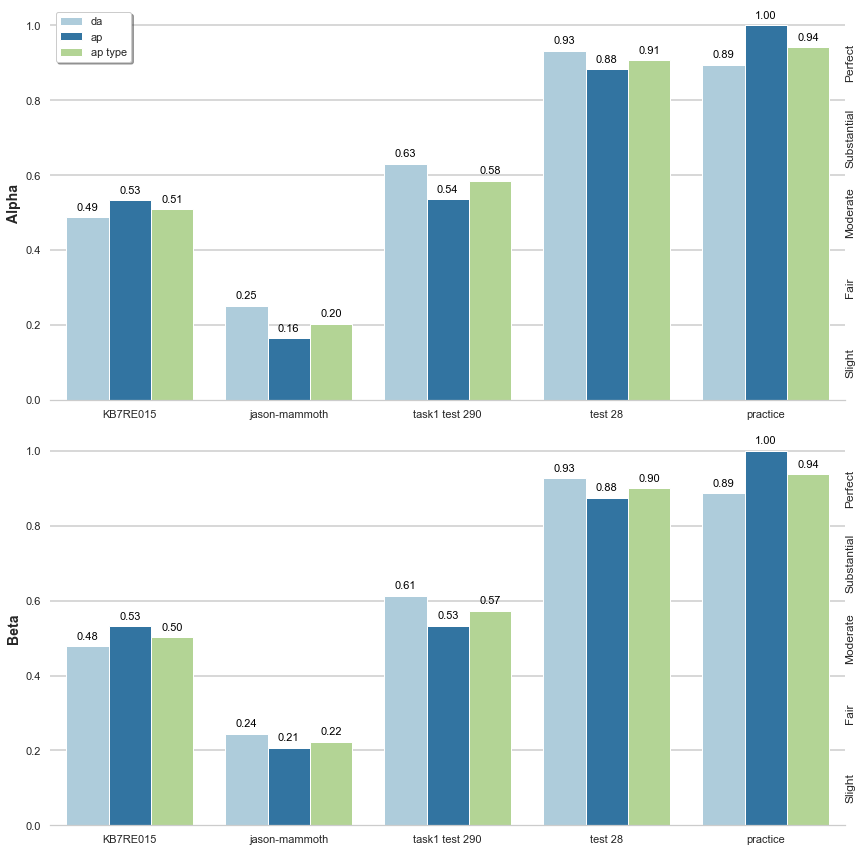

In [26]:
# Generate a group plot for all stats
data = nd_cs_agreement.reset_index(drop=False, col_level=0)
data = data.melt(id_vars=['index'])
data = data.rename(columns={'variable_0': 'metric', 'variable_1': 'group'})
data['metric'] = data['metric'].str.capitalize()

g, plt = plot_facetgrid(data, title='', axis_titles=True, share_y=False, num_col=1, show_bar_value=True,
                        legend_loc='upper left', num_legend_col=1, errcolor='#CCCCCC', errwidth=1.5)
g, plt = annotate_landis_koch(g, plt)  # Annotate with landis and koch range
plt.savefig('set1_expert_agreement.png')

# Me and Participants Inter-annotator Agreement

In [4]:
# Load my data
my_data = load_user_data(my_data_dir)

# Load unique labels and merge with existing
my_labels = load_labels(labels_dir, my_data)
labels['ap_type'] = list(set(labels['ap_type']).union(set(my_labels['ap_type'])))

# Get the label data (if adding new data set load=False)
my_label_data = get_user_label_data(os.path.join(agreement_data_dir, 'nd_label_data.pkl'), my_data, labels, sets_list, dialogue_groups, load=True)
user_label_data = get_user_label_data(os.path.join(agreement_data_dir, 'user_label_data.pkl'), user_data, labels, sets_list, dialogue_groups, load=True)

# Calculate pairwise agreement, for each user and for all dialogues
agreement_frame = pd.DataFrame()
for group in dialogue_type_groups + ['practice_dialogue']:
    for dialogue_name in dialogue_groups[group]:

        # Get my data for this dialogue
        my_current_id = list(my_label_data[group][dialogue_name].keys())[0]  # Have to get my user id
        my_current = my_label_data[group][dialogue_name][my_current_id]

        # For each user get agreement
        for user in user_label_data[group][dialogue_name]:
            user_current_data = user_label_data[group][dialogue_name][user]

            # Calculate Alpha and Beta
            tmp_data = {dialogue_name: {'nd': my_current, user: user_current_data}}
            alpha_r = get_weighted_agreement(tmp_data, labels, 'alpha', add_mean=False)
            beta_r = get_weighted_agreement(tmp_data, labels, 'beta', add_mean=False)

            # Add metadata and concat to frame
            user_frame = pd.concat([alpha_r, beta_r], axis=1)
            user_frame.insert(loc=0, column='user', value=user)
            # Add corpus and dialogue name
            for corpus_name in dialogue_corpora_groups + ['practice_dialogue']:
                if dialogue_name in dialogue_groups[corpus_name]:
                    user_frame.insert(loc=0, column='dialogue', value=dialogue_name.replace('_', ' '))
                    user_frame.insert(loc=0, column='corpus', value=corpus_name.split('_')[0])
            # Add set and group name
            for set_name in dialogue_sets.keys():
                if dialogue_name in dialogue_sets[set_name]:
                    user_frame.insert(loc=0, column='group', value=group.split('_')[0])
                    user_frame.insert(loc=0, column='set', value=set_name.replace('_', ' '))

            # Add to frame
            agreement_frame = pd.concat([agreement_frame, user_frame], axis=0)

agreement_frame.reset_index(drop=True, inplace=True)
agreement_frame

set              group    corpus        dialogue     user     alpha                          beta                        
                                                                                   da        ap   ap type        da            ap   ap type
0               set 1      task-oriented     kvret         test 28   usr1-1  0.932827  0.087719  0.504262  0.928032  5.084746e-02  0.476770
1               set 1      task-oriented     kvret         test 28  usr11-1  1.000000  0.327586  0.653444  1.000000  2.881356e-01  0.630073
2               set 1      task-oriented     kvret         test 28   usr6-1  0.776048  0.458333  0.612583  0.762687  4.262295e-01  0.589556
3               set 2      task-oriented     kvret         test 52  usr12-2  0.495924 -0.077844  0.215783  0.482253 -1.162791e-01  0.191294
4               set 2      task-oriented     kvret         test 52   usr2-2  0.635396  0.230769  0.438649  0.617728  2.000000e-01  0.413771
5               set 2      task-oriented     kvret         test 52   usr7-2  0.347284 -0.050955  0.160793  0.330757 -4.761905e-02  0.151002
6               set 3      task-oriented     kvret         test 96  usr13-3  0.416752 -0.166667  0.122432  0.400070  6.666667e-02  0.211140
7               set 3      task-oriented     kvret         test 96   usr3-3  0.898448  0.222222  0.623638  0.885600  2.500000e-01  0.603155
8               set 3      task-oriented     kvret         test 96   usr8-3  0.898448  0.102564  0.502728  0.885600  1.666667e-01  0.493501
9               set 4      task-oriented     kvret        test 129  usr14-4  0.793118 -0.076087  0.356728  0.778477  5.263158e-02  0.378678
10              set 4      task-oriented     kvret        test 129   usr4-4  1.000000  0.607143  0.843874  1.000000  6.000000e-01  0.834382
11              set 4      task-oriented     kvret        test 129   usr9-4  0.925341  0.352941  0.669870  0.919102  4.285714e-01  0.675192
12              set 5      task-oriented     kvret        test 102  usr10-5  0.695683  0.363636  0.544671  0.666699  4.000000e-01  0.535489
13              set 5      task-oriented     kvret        test 102  usr15-5  0.695683  0.222222  0.469989  0.666699  2.727273e-01  0.463360
14              set 5      task-oriented     kvret        test 102   usr5-5  0.599930  0.500000  0.559078  0.567496  5.000000e-01  0.538710
15              set 1      task-oriented      babl  task1 test 290   usr1-1  0.301743  0.409091  0.355891  0.280582  4.084507e-01  0.345962
16              set 1      task-oriented      babl  task1 test 290  usr11-1  0.626561 -0.108527  0.244926  0.612893 -1.000000e-01  0.234998
17              set 1      task-oriented      babl  task1 test 290   usr6-1  0.634673  0.015152  0.319857  0.613861  1.408451e-02  0.300967
18              set 2      task-oriented      babl  task1 test 428  usr12-2  0.502454  0.325926  0.408877  0.479126  3.000000e-01  0.383819
19              set 2      task-oriented      babl  task1 test 428   usr2-2  0.426934 -0.074380  0.185140  0.419022 -7.692308e-02  0.178378
20              set 2      task-oriented      babl  task1 test 428   usr7-2  0.444239 -0.258065  0.095737  0.426026 -9.090909e-02  0.146974
21              set 3      task-oriented      babl  task1 test 555  usr13-3  0.222575 -0.142857  0.047078  0.165767 -5.263158e-02  0.052666
22              set 3      task-oriented      babl  task1 test 555   usr3-3  0.623421  0.739130  0.688189  0.602877  7.222222e-01  0.669383
23              set 3      task-oriented      babl  task1 test 555   usr8-3  0.073364  0.260274  0.170224  0.058929  2.857143e-01  0.179240
24              set 4      task-oriented      babl  task1 test 564  usr14-4  0.521600  0.400000  0.456376  0.503102  3.902439e-01  0.441971
25              set 4      task-oriented      babl  task1 test 564   usr4-4  0.305490 -0.058824  0.121553  0.311683 -8.108108e-02  0.116270
26              set 4      task-oriented      babl  task1 test 564   usr9-4  0.540964  0.347826  0

## Dialogue Sets

In [5]:
# Group the set data
set_frame = agreement_frame.drop(agreement_frame[agreement_frame.set == 'practice dialogue'].index)
set_frame = set_frame.drop(['dialogue', 'group', 'corpus'], axis=1)
set_frame = set_frame.groupby(['set', 'user']).mean()
set_frame.reset_index(inplace=True)
set_frame

c:\python\virtual environments\venv-tf-1.15\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


set     user     alpha                          beta                    
                          da        ap   ap type        da        ap   ap type
0   set 1   usr1-1  0.514181  0.324540  0.414760  0.504767  0.324979  0.408185
1   set 1  usr11-1  0.573882  0.187138  0.376611  0.578848  0.169620  0.368238
2   set 1   usr6-1  0.512642  0.199745  0.353595  0.510056  0.198361  0.349540
3   set 2  usr12-2  0.280699 -0.007167  0.140494  0.268899 -0.027366  0.123607
4   set 2   usr2-2  0.354306  0.166014  0.261836  0.347600  0.154684  0.251923
5   set 2   usr7-2  0.262242 -0.147110  0.063335  0.258855 -0.053744  0.098425
6   set 3  usr13-3  0.394527 -0.001547  0.202614  0.368329  0.089577  0.223345
7   set 3   usr3-3  0.505572  0.363555  0.444327  0.486017  0.379311  0.438483
8   set 3   usr8-3  0.454976  0.176804  0.302796  0.442068  0.211976  0.306543
9   set 4  usr14-4  0.432822 -0.040850  0.180600  0.427766  0.064996  0.220763
10  set 4   usr4-4  0.515729  0.268117  0.382443  0.529704  0.290163  0.400666
11  set 4   usr9-4  0.620953  0.377365  0.511980  0.622578  0.392837  0.509837
12  set 5  usr10-5  0.557620  0.280374  0.411838  0.535648  0.306921  0.407125
13  set 5  usr15-5  0.391491  0.455753  0.427294  0.374079  0.466913  0.419354
14  set 5   usr5-5  0.431064  0.443071  0.423158  0.408724  0.440159  0.405922

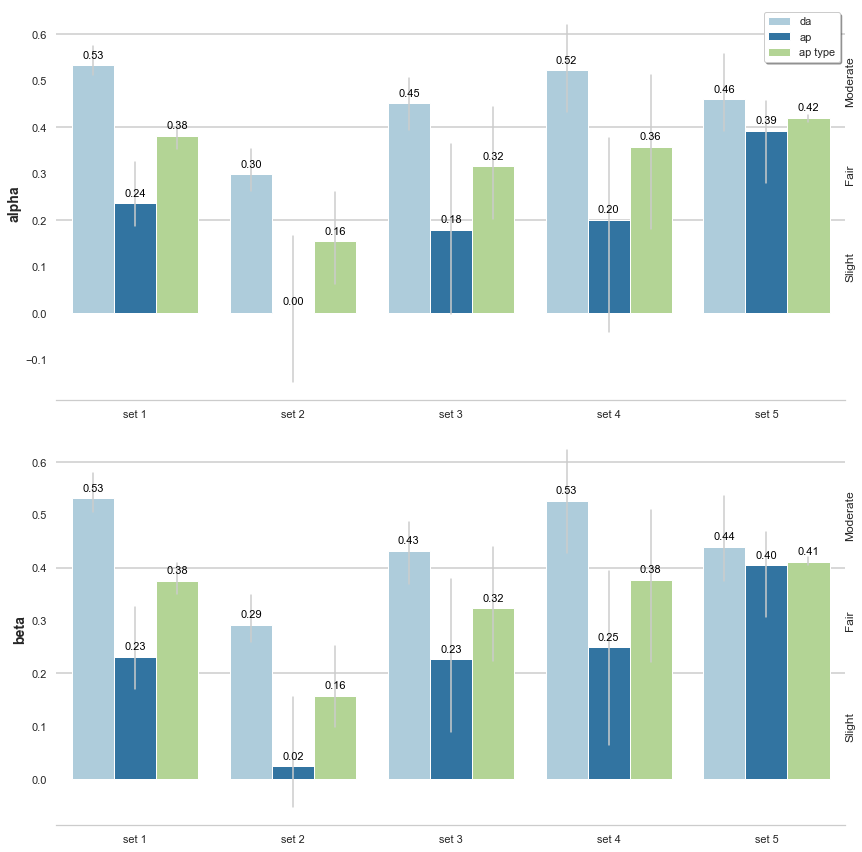

In [6]:
# Generate a group plot for all stats
data = set_frame.melt(id_vars=['set', 'user'])
data = data.rename(columns={'set':'index', 'variable_0': 'metric', 'variable_1': 'group'})

g, plt = plot_facetgrid(data, title='', axis_titles=True, share_y=False, num_col=1, show_bar_value=True,
                        legend_loc='upper right', num_legend_col=1, errcolor='#CCCCCC', errwidth=1.5)
g, plt = annotate_landis_koch(g, plt)  # Annotate with landis and koch range

# Task and Non-task Dialogue

In [7]:
# Group the task/non-task data
type_frame = agreement_frame.drop(['set', 'dialogue', 'corpus'], axis=1)
type_frame = type_frame.groupby(['group', 'user'], sort=False).mean()
type_frame.reset_index(inplace=True)
type_frame

c:\python\virtual environments\venv-tf-1.15\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


group     user     alpha                          beta                    
                                      da        ap   ap type        da        ap   ap type
0       task-oriented   usr1-1  0.617285  0.248405  0.430076  0.604307  0.229649  0.411366
1       task-oriented  usr11-1  0.813280  0.109530  0.449185  0.806446  0.094068  0.432536
2       task-oriented   usr6-1  0.705361  0.236742  0.466220  0.688274  0.220157  0.445261
3       task-oriented  usr12-2  0.499189  0.124041  0.312330  0.480690  0.091860  0.287557
4       task-oriented   usr2-2  0.531165  0.078195  0.311894  0.518375  0.061538  0.296075
5       task-oriented   usr7-2  0.395762 -0.154510  0.128265  0.378392 -0.069264  0.148988
6       task-oriented  usr13-3  0.319663 -0.154762  0.084755  0.282919  0.007018  0.131903
7       task-oriented   usr3-3  0.760935  0.480676  0.655914  0.744238  0.486111  0.636269
8       task-oriented   usr8-3  0.485906  0.181419  0.336476  0.472265  0.226190  0.336370
9       task-oriented  usr14-4  0.657359  0.161957  0.406552  0.640789  0.221438  0.410325
10      task-oriented   usr4-4  0.652745  0.274160  0.482714  0.655842  0.259459  0.475326
11      task-oriented   usr9-4  0.733152  0.350384  0.557624  0.716552  0.367063  0.543180
12      task-oriented  usr10-5  0.522874  0.474126  0.503494  0.504291  0.491667  0.496718
13      task-oriented  usr15-5  0.502247  0.478758  0.494541  0.477757  0.493506  0.478423
14      task-oriented   usr5-5  0.472375  0.364286  0.423154  0.454689  0.355263  0.408022
15  non-task-oriented   usr1-1  0.411077  0.400675  0.399445  0.405228  0.420308  0.405004
16  non-task-oriented  usr11-1  0.334483  0.264746  0.304037  0.351250  0.245173  0.303940
17  non-task-oriented   usr6-1  0.319923  0.162747  0.240971  0.331838  0.176564  0.253818
18  non-task-oriented  usr12-2  0.062208 -0.138376 -0.031342  0.057108 -0.146593 -0.040342
19  non-task-oriented   usr2-2  0.177448  0.253833  0.211777  0.176826  0.247829  0.207771
20  non-task-oriented   usr7-2  0.128722 -0.139710 -0.001594  0.139318 -0.038225  0.047861
21  non-task-oriented  usr13-3  0.469390  0.151668  0.320474  0.453740  0.172137  0.314786
22  non-task-oriented   usr3-3  0.250210  0.246434  0.232740  0.227796  0.272510  0.240698
23  non-task-oriented   usr8-3  0.424045  0.172190  0.269117  0.411871  0.197761  0.276716
24  non-task-oriented  usr14-4  0.208285 -0.243657 -0.045352  0.214743 -0.091445  0.031201
25  non-task-oriented   usr4-4  0.378713  0.262075  0.282172  0.403565  0.320867  0.326005
26  non-task-oriented   usr9-4  0.508754  0.404345  0.466336  0.528603  0.418611  0.476495
27  non-task-oriented  usr10-5  0.592366  0.086623  0.320182  0.567005  0.122174  0.317532
28  non-task-oriented  usr15-5  0.280735  0.432748  0.360046  0.270400  0.440319  0.360285
29  non-task-oriented   usr5-5  0.389753  0.521856  0.423163  0.362758  0.525054  0.403822
30           practice   usr1-1  0.925341  0.388889  0.678316  0.919102  0.368421  0.659043
31           practice  usr10-5  0.925341  0.352941  0.638054  0.919102  0.333333  0.617728
32           practice  usr11-1  0.925341  0.037500  0.493173  0.919102  0.045455  0.474507
33           practice  usr12-2  0.722334  0.250000  0.489799  0.704549  0.265306  0.479234
34           practice  usr13-3  0.774759 -0.122449  0.290986  0.760815  0.000000  0.317700
35           practice  usr14-4  0.925341 -0.053191  0.409600  0.919102 -0.038462  0.391971
36           practice  usr15-5  1.000000  0.505618  0.743626  1.000000  0.500000  0.731279
37           practice   usr2-2  0.925341  0.488372  0.704755  0.919102  0.500000  0.696737
38           practice   usr3-3  0.851688  0.185185  0.526351  0.842453  0.181818  0.510685
39           practice   usr4-4  1.000000  0.320988  0.663863  1.000000  0.318182  0.648350
40           practice   usr5-5  1.000000  0.463415  0.732724  1.000000  0.454545  0.718680
41           practice   usr6-1  1.000000  0.611765  0.803131  1.000000  0.600000  0.791454
42          

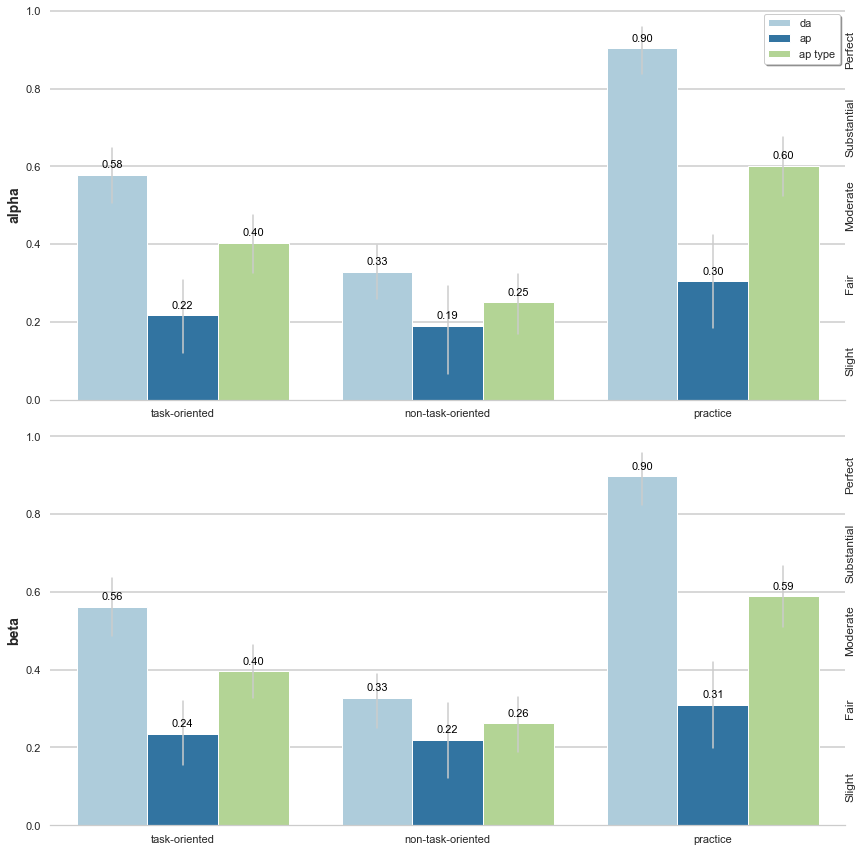

In [8]:
# Generate a group plot for all stats
data = type_frame.melt(id_vars=['group', 'user'])
data = data.rename(columns={'group':'index', 'variable_0': 'metric', 'variable_1': 'group'})

g, plt = plot_facetgrid(data, title='', axis_titles=True, share_y=False, num_col=1, show_bar_value=True,
                        legend_loc='upper right', num_legend_col=1, errcolor='#CCCCCC', errwidth=1.5)
g, plt = annotate_landis_koch(g, plt)

# Corpus Dialogue

In [9]:
# Group the set data
corpus_frame = agreement_frame.drop(agreement_frame[agreement_frame.set == 'practice dialogue'].index)
corpus_frame = corpus_frame.drop(['set', 'dialogue', 'group'], axis=1)
corpus_frame = corpus_frame.groupby(['corpus', 'user'], sort=False).mean()
corpus_frame.reset_index(inplace=True)
corpus_frame

c:\python\virtual environments\venv-tf-1.15\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


corpus     user     alpha                          beta                        
                          da        ap   ap type        da            ap   ap type
0   kvret   usr1-1  0.932827  0.087719  0.504262  0.928032  5.084746e-02  0.476770
1   kvret  usr11-1  1.000000  0.327586  0.653444  1.000000  2.881356e-01  0.630073
2   kvret   usr6-1  0.776048  0.458333  0.612583  0.762687  4.262295e-01  0.589556
3   kvret  usr12-2  0.495924 -0.077844  0.215783  0.482253 -1.162791e-01  0.191294
4   kvret   usr2-2  0.635396  0.230769  0.438649  0.617728  2.000000e-01  0.413771
5   kvret   usr7-2  0.347284 -0.050955  0.160793  0.330757 -4.761905e-02  0.151002
6   kvret  usr13-3  0.416752 -0.166667  0.122432  0.400070  6.666667e-02  0.211140
7   kvret   usr3-3  0.898448  0.222222  0.623638  0.885600  2.500000e-01  0.603155
8   kvret   usr8-3  0.898448  0.102564  0.502728  0.885600  1.666667e-01  0.493501
9   kvret  usr14-4  0.793118 -0.076087  0.356728  0.778477  5.263158e-02  0.378678
10  kvret   usr4-4  1.000000  0.607143  0.843874  1.000000  6.000000e-01  0.834382
11  kvret   usr9-4  0.925341  0.352941  0.669870  0.919102  4.285714e-01  0.675192
12  kvret  usr10-5  0.695683  0.363636  0.544671  0.666699  4.000000e-01  0.535489
13  kvret  usr15-5  0.695683  0.222222  0.469989  0.666699  2.727273e-01  0.463360
14  kvret   usr5-5  0.599930  0.500000  0.559078  0.567496  5.000000e-01  0.538710
15   babl   usr1-1  0.301743  0.409091  0.355891  0.280582  4.084507e-01  0.345962
16   babl  usr11-1  0.626561 -0.108527  0.244926  0.612893 -1.000000e-01  0.234998
17   babl   usr6-1  0.634673  0.015152  0.319857  0.613861  1.408451e-02  0.300967
18   babl  usr12-2  0.502454  0.325926  0.408877  0.479126  3.000000e-01  0.383819
19   babl   usr2-2  0.426934 -0.074380  0.185140  0.419022 -7.692308e-02  0.178378
20   babl   usr7-2  0.444239 -0.258065  0.095737  0.426026 -9.090909e-02  0.146974
21   babl  usr13-3  0.222575 -0.142857  0.047078  0.165767 -5.263158e-02  0.052666
22   babl   usr3-3  0.623421  0.739130  0.688189  0.602877  7.222222e-01  0.669383
23   babl   usr8-3  0.073364  0.260274  0.170224  0.058929  2.857143e-01  0.179240
24   babl  usr14-4  0.521600  0.400000  0.456376  0.503102  3.902439e-01  0.441971
25   babl   usr4-4  0.305490 -0.058824  0.121553  0.311683 -8.108108e-02  0.116270
26   babl   usr9-4  0.540964  0.347826  0.445379  0.514002  3.055556e-01  0.411168
27   babl  usr10-5  0.350065  0.584615  0.462316  0.341883  5.833333e-01  0.457947
28   babl  usr15-5  0.308810  0.735294  0.519092  0.288815  7.142857e-01  0.493487
29   babl   usr5-5  0.344820  0.228571  0.287230  0.341883  2.105263e-01  0.277334
30  scose   usr1-1  0.469049  0.141350  0.294296  0.467642  1.867704e-01  0.313873
31  scose  usr11-1  0.229399  0.405782  0.315081  0.271939  4.087137e-01  0.336584
32  scose   usr6-1  0.252655  0.020948  0.136095  0.282338  6.365503e-02  0.172039
33  scose  usr12-2  0.040512  0.064712  0.052599  0.083814  7.045010e-02  0.077398
34  scose   usr2-2  0.244987  0.154725  0.197936  0.239183  1.623246e-01  0.198811
35  scose   usr7-2 -0.016445 -0.141489 -0.076996  0.038300 -5.758157e-02 -0.008604
36  scose  usr13-3  0.394216  0.178336  0.270096  0.413652  2.014162e-01  0.291837
37  scose   usr3-3  0.482853  0.129232  0.273583  0.487778  1.450199e-01  0.284195
38  scose   usr8-3  0.477553 -0.019257  0.170380  0.483009  6.218905e-02  0.215638
39  scose  usr14-4  0.151779 -0.197840 -0.067825  0.168835 -1.059671e-01 -0.007535
40  scose   usr4-4  0.665400  0.201569  0.360138  0.660902  3.084016e-01  0.416802
41  scose   usr9-4  0.154914  0.308691  0.247935  0.211218  3.372216e-01  0.286583
42  scose  usr10-5  0.737406  0.216724  0.445368  0.732346  2.443488e-01  0.452053
43  scose  usr15-5  0.431005  0.557803  0.496560  0.425704  5.563140e-01  0.493509
44  scose   usr5-5  0.736686  0.213523  0.457163  0.730556  2.352941e-01  0.459679
45  cabnc   usr1-1  0.353106  0.660000  0.504593  0.342814  6.538462e-01  0.496135
46  cabnc  usr11-1 

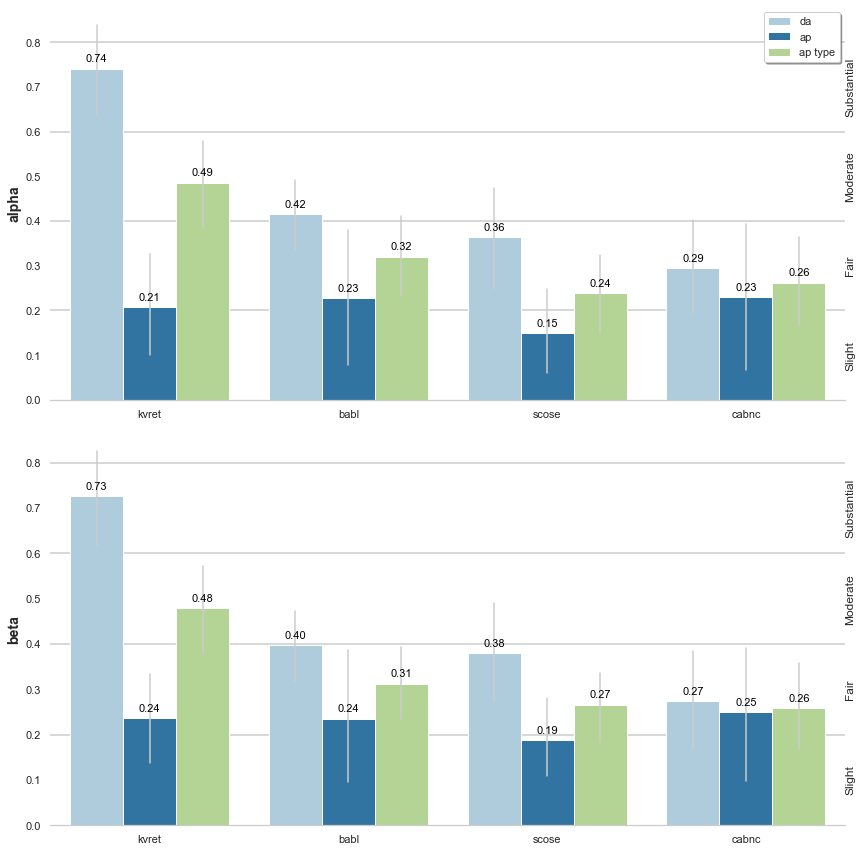

In [10]:
# Generate a group plot for all stats
data = corpus_frame.melt(id_vars=['corpus', 'user'])
data = data.rename(columns={'corpus':'index', 'variable_0': 'metric', 'variable_1': 'group'})

g, plt = plot_facetgrid(data, title='', axis_titles=True, share_y=False, num_col=1, show_bar_value=True,
                        legend_loc='upper right', num_legend_col=1, errcolor='#CCCCCC', errwidth=1.5)
g, plt = annotate_landis_koch(g, plt)
